In [ ]:
import equinox as eqx
import jax.numpy as jnp
from jaxNRSur.SurrogateModel import NRHybSur3dq8Model
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
time = jnp.linspace(-1000, 100, 100000)
params = jnp.array([0.9, 0.1, 0.1])
model = NRHybSur3dq8Model("../NRHybSur3dq8.h5")

In [3]:
h = model.get_waveform(time, params)

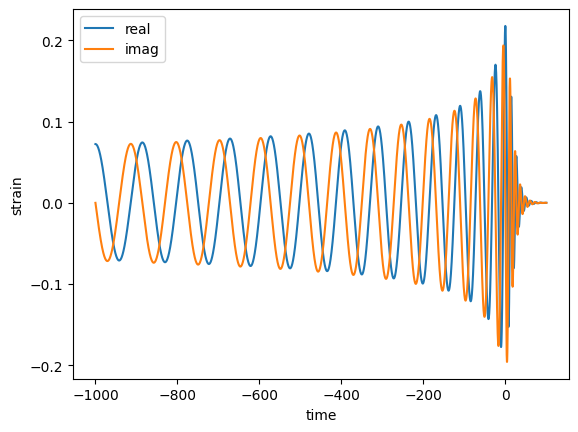

In [4]:
# Plot the waveform
plt.plot(time, h.real, label="real")
plt.plot(time, h.imag, label="imag")
plt.xlabel("time")
plt.ylabel("strain")
plt.legend()
plt.show()

In [5]:
# Compute the gradient of the waveform with respect to the parameters
def sum_f(params):
    return jnp.sum(model.get_waveform(time, params).real)
grad_f = eqx.filter_jit(eqx.filter_grad(sum_f))

In [7]:
grad_f(params)

Array([  2.64598034, 171.76840892, -17.00368469], dtype=float64)

In [9]:
# Vmap the waveform to compute the waveform for multiple parameters
params_multi = jnp.array([[0.9, 0.1, 0.1]])
params_multi = jnp.repeat(params_multi, 10, axis=0)
h_multi = eqx.filter_jit(eqx.filter_vmap(model.get_waveform, in_axes=(None, 0, None, None)))(
    time, params_multi
)